In [44]:
#@title Imports external sources
import os
import io
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import base64
import zipfile
import json
import requests
import matplotlib.pylab as pl
import numpy as np
import glob
import requests
import random as pyrandom
from concurrent import futures
from functools import partial
from scipy.ndimage import rotate
from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange
import time
from typing import Any, MutableMapping, NamedTuple, Tuple

In [45]:
import pickle

In [46]:
# !pip install --quiet --upgrade jax
# !pip install --quiet --upgrade jaxlib
!pip install --quiet jax==0.4.30 jaxlib==0.4.30 #0.4.31 is not compatible, so please do not update
import jax
from jax import grad, jit, vmap
import jax.numpy as jnp

!pip install --quiet -U dm-haiku
!pip install --quiet -U optax
import haiku as hk
import math
!pip install --quiet -U ml_collections
from ml_collections import config_dict
import matplotlib.pylab as pl
import matplotlib.colors as mcolors
colors = pl.colormaps['Dark2']

/opt/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [47]:
!pip show -f pandas numpy tensorflow jax jaxlib | grep Version

Version: 2.2.1
Version: 1.26.4
Version: 2.16.1
  tensorflow/include/external/stablehlo/_virtual_includes/version/stablehlo/dialect/Version.h
  tensorflow/include/external/stablehlo/stablehlo/dialect/Version.h
Version: 0.4.30
Version: 0.4.30


In [48]:
!python --version

Python 3.11.7


In [49]:
os.environ['JAX_PLATFORMS'] = 'gpu'
os.environ['ENABLE_PJRT_COMPATIBILITY'] = 'true'

In [50]:
%pwd

'/Users/evanli/Desktop/transformers-learn-in-context-by-gradient-descent-main'

In [51]:
from src.transformer import Transformer
from src.data import create_reg_data, create_weights
from src.config import config
from src.train import *

In [52]:
#@title Config
softmax = False #@param {type:"boolean"}
layernorm = False #@param {type:"boolean"}

recurrent_Transformer = True #@param {type:"boolean"}
num_layers = 1 #@param {type:"integer"}
num_heads = 1 #@param {type:"integer"}
num_seeds = 1 #@param {type:"integer"}

config.seed = 0
config.local_usage = True

####
config.deq = recurrent_Transformer
config.gd_deq = recurrent_Transformer 
config.att_only_trans = True
####

config.pre_train_gd = True
config.train_gd_whitening = True
config.train_gd_lr = True
config.use_bias = False
config.include_query = False

config.distract_size = 0
config.training_steps = 1500 if config.deq else 50000
config.training_steps_gd = 1500 if config.gd_deq else 30000
config.use_softmax = softmax
config.first_layer_sm = False
config.use_non_lin_mix = False

config.widening_factor = 4

config.layer_norm = layernorm
config.out_proj = False
config.in_proj = False
config.adam = True
config.dataset_size = 10
config.input_size = 1
config.key_size = 2
config.num_layers = num_layers
config.num_heads = num_heads

config.grad_clip_value = 10 if num_layers > 2 else 0.001
config.grad_clip_value_gd = 10 if num_layers > 2 else 0.001
config.lr = 0.0005 if num_layers > 3 else 0.001
config.gd_lr = 0.0005 if num_layers > 3 else 0.001
config.wd = 0.0
config.init_scale = 0.002 / config.num_layers
config.bs = 2048
config.bs_gd_train = 512
config.dampening = 1.0
config.clip = 10 if num_layers > 3 else 0 

config.dropout_rate = 0.0
# data_creator outputs a tuple with three elements, each representing a different aspect of the generated data
# seqs: (num_heads, config.dataset_size + 1, config.input_size + 1), target: (num_heads, 1, config.input_size + 1), ws: (batch_size, config.input_size)
data_creator = vmap(create_reg_data,
                    in_axes=(0, None, None, None, None, None),
                    out_axes=0) # vmap expects a batch of random number generators, one for each batch element

config.y_update = False
config.input_range = 1

config.pos_enc = False
config.pos_enc_size = 20
config.concat_pos_enc = False
config.analyse = True

config.cycle_data = 0 #0 means online learning
config.num_seeds = num_seeds
if config.num_layers == 1:
  assert config.deq == True
  assert config.gd_deq == True

if config.num_layers > 1:
  assert config.y_update == False

config.in_proj = False
config.emb_size = 11

In [53]:
#@title Utils
pl.rcParams.update({'font.size': 12})
pl.rc('axes', labelsize=14)
pl.rcParams.update({
    "text.usetex": False,
})

import matplotlib.colors as mcolors
colors = pl.colormaps['Dark2']
def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb') #GFile.open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def grab_plot(close=True):
  """Return the current Matplotlib figure as an image."""
  fig = pl.gcf()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)
  a = np.float32(img[..., 3:]/255.0)
  img = np.uint8(255*(1.0-a) + img[...,:3] * a)  # alpha
  if close:
    pl.close()
  return img

def display_learning(train, test=None, gt=None, inter=None, title="train",
                     title1="Trained TF", title2="Test",
                     title3='Gradient descent', title4='Interpolated',
                     y_label1 = 'L2 Norm', y_label2 = 'Cosine sim',
                     y_lim_l=0,  y_lim_u=1, single_seeds= False,
                     plot_title = None,
                     y_lim_u2= 1., y_lim_l2=0.,  x_label = 'Training steps',
                     second_axis=False, color_add=0, rw=10, num_iter_os=None,
                     allow_download=False, plot_num=1, two_plots=False,
                     loc_first = 'upper left', label_title="Loss",
                     loc_sec='upper left', yscale_log=False, line="-",
                     color_axis=True,
                     height=3.5, width = 4, ax1=None, ax2=None):

  """Update learning curve image."""

  train_list = train
  train = np.array(train)
  num_seeds_train = train.shape[0]
  train_std = np.std(train, axis=0)
  train = np.mean(train, axis=0)

  if test is not None:
    test_list = test
    test_std = np.std(test, axis=0)
    test = np.mean(test, axis=0)

  if gt is not None:
    gt_list = gt
    gt_std = np.std(gt, axis=0)
    gt = np.mean(gt, axis=0)

  if inter is not None:
    inter_list = inter
    inter_std = np.std(inter, axis=0)
    inter = np.mean(inter, axis=0)

  if plot_num == 1:
    fig, ax1 = pl.subplots()
    ax1.set_xlabel(x_label)
    fig.set_size_inches(width, height)


  if test is not None and not second_axis:
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(test)))
    if len(test_list) > 1:
      if single_seeds:
        for s in test_list:
          ax1.plot(x_range, s, color=colors(0.1+color_add), alpha=0.2, label=title2,linewidth='2')
      else:
        ax1.fill_between(x_range, test-test_std, test+test_std ,alpha=0.2, facecolor=colors(0.1+color_add))
    ax1.plot(x_range, test, color=colors(0.1+color_add), label=title2,linewidth='3')
    #test_avg = moving_average(test, rw)
    #ax1.plot(x_range[:len(test_avg)], test_avg, color=colors(0.1+color_add), label=title2)

  if gt is not None:
    if not second_axis:
      x_range = np.arange(0, num_iter_os, int(num_iter_os/len(gt)))
      #ax1.plot(x_range[:len(gt[:-rw])], gt[:-rw], color=colors(0.2+color_add), alpha=0.3)
      #gt_avg = moving_average(gt, rw)
      ax1.plot(x_range, gt, color=colors(0.2+color_add), label=title3,linewidth='3')
      if len(gt_list) > 1:
        if single_seeds:
          for s in gt_list:
            ax1.plot(x_range, s, color=colors(0.2+color_add), alpha=0.2, linewidth='2', zorder=0)
        else:
          ax1.fill_between(x_range, gt-gt_std, gt+gt_std,alpha=0.2, facecolor=colors(0.2+color_add))
    else:
      x_range = np.arange(0, num_iter_os, int(num_iter_os/len(gt)))
      ax1.plot(x_range, gt, color=colors(0.6+color_add), label=title3,linewidth='3')
      if len(gt_list) > 1:
        if single_seeds:
          for s in gt_list:
            ax1.plot(x_range, s, color=colors(0.6+color_add), alpha=0.3, linewidth='2', zorder=0)
        else:
          ax1.fill_between(x_range, gt-gt_std, gt+gt_std ,alpha=0.2, facecolor=colors(0.6+color_add))

  if test is not None and second_axis:
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(test)))
    ax1.plot(x_range, test, color=colors(0.5+color_add), label=title2,linewidth='3')
    #test_avg = moving_average(test, rw)
    #ax1.plot(x_range[:len(test_avg)],test_avg, color=colors(0.5+color_add))
    if len(test_list) > 1:
      if single_seeds:
        for s in test_list:
          ax1.plot(x_range, s, color=colors(0.5+color_add), linewidth='2', alpha=0.3, zorder=0)
      else:
        ax1.fill_between(x_range, test-test_std, test+test_std ,alpha=0.2, facecolor=colors(0.5+color_add))

  if inter is not None and not second_axis:
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(inter)))
    ax1.plot(x_range, inter, color=colors(0.4+color_add), label=title4, linewidth='3', zorder=10)
    if len(inter_list) > 1:
      if single_seeds:
        for s in inter_list:
          ax1.plot(x_range, s, color=colors(0.4+color_add), alpha=0.3, linewidth='2', zorder=0)
      else:
        ax1.fill_between(x_range, inter-inter_std, inter+inter_std ,alpha=0.2, facecolor=colors(0.4+color_add), zorder=1)
    #inter_avg = moving_average(inter, rw)
    #ax1.plot(x_range[:len(inter_avg)], inter_avg, color=colors(0.7+color_add), label=title4)


  if second_axis:
    if ax2 is None:
      ax2 = ax1.twinx()
    ax2.set_zorder(0)
    ax1.set_zorder(1)
    ax1.set_frame_on(False)
    #train_avg = moving_average(train, rw)
    #ax2.plot(train[:-rw], color=colors(0.1+color_add), alpha=0.3)
    ax2.plot(x_range, train, color=colors(0.4+color_add), label=title1, linewidth='3')
    ax2.plot(x_range, np.ones_like(train), "--", color="gray", linewidth='0.7')
    if len(train_list) > 1:
      if single_seeds:
        for s in train_list:
          print(x_range, s)
          ax1.plot(x_range, s, line, color=colors(0.4+color_add), alpha=0.3, linewidth='2', zorder=0)
      else:
        ax2.fill_between(x_range, train-train_std, train+train_std ,alpha=0.2, facecolor=colors(0.4+color_add))

    if color_axis:
      ax2.yaxis.label.set_color(colors(0.4+color_add))
    else:
      legend2 = ax2.legend(loc='upper right', framealpha=0.99, facecolor='white')
      legend2.set_zorder(100)
    ax2.spines['top'].set_visible(False)
  else:
    #train_avg = moving_average(train, rw)
    if line != "-":
      ax1.scatter(x_range, train, s=[100 for _ in x_range],
                  marker="+", color=colors(0.3+color_add), alpha=1, label=title1, zorder=3, linewidths=3)
    else:
      ax1.plot(x_range, train, line, color=colors(0.3+color_add), label=title1, linewidth='3', zorder=11)
    #ax1.plot(x_range[:len(train_avg)], train_avg, line, color=colors(0.3+color_add), label=title1)
    if len(train_list) > 1:
      if single_seeds:
          for s in train_list:
            ax1.plot(x_range, s, line, color=colors(0.3+color_add), alpha=0.3, linewidth='2', zorder=0)
      else:
        ax1.fill_between(x_range, train-train_std, train+train_std,
                       alpha=0.5, facecolor=colors(0.3+color_add))

    ax1.legend(loc='best', framealpha=1, facecolor='white')
    ax1.spines['right'].set_visible(False)
    legend = ax1.legend(loc='upper right', framealpha=0.99, facecolor='white')
    legend.set_zorder(100)

  legend1 = ax1.legend(loc=loc_first, framealpha=0.99, facecolor='white')
  legend1.set_zorder(100)
  if second_axis:
    ax2.set_ylabel(y_label2)
    ax1.set_ylabel(y_label1)
    ax1.set_ylim(y_lim_l, y_lim_u)
    legend1 = ax1.legend(loc=loc_sec, framealpha=0.99, facecolor='white')
    ax2.set_ylim(y_lim_l2, y_lim_u2)
    ax1.set_ylim(bottom=0)
  else:
    pl.ylabel(label_title)
    pl.ylim(y_lim_l, y_lim_u)
  ax1.spines['top'].set_visible(False)

  if plot_title is not None:
    pl.title(plot_title)

  if yscale_log:
    ax1.set_yscale("log")
  #pl.title(title)
  pl.tight_layout()

  if allow_download:
    if second_axis:
      pl.savefig("sim.pdf", format="pdf")
      %download_file sim.pdf
    else:
      pl.savefig("train.pdf", format="pdf")
      %download_file train.pdf
  else:
    img = grab_plot()
    display(Image(data=imencode(img, fmt='jpeg')), display_id=title)


In [54]:
#@title Lists

loss_trans_list =  [[]  for _ in range(config.num_seeds)]
loss_trans_train_list =  [[]  for _ in range(config.num_seeds)]
losses_gd_list =  [[]  for _ in range(config.num_seeds)]
losses_gd_list_trained =  [[]  for _ in range(config.num_seeds)]
losses_int_list_trained =  [[]  for _ in range(config.num_seeds)]
cos_sim_list, cos_sim_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]
grad_norm_list, grad_norm_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]
p_norm_list, p_norm_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]

cos_sim_list, cos_sim_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]
grad_norm_list, grad_norm_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]
p_norm_list, p_norm_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]

ir_t_list = [[]  for _ in range(config.num_seeds)]
ws_t_list = [[]  for _ in range(config.num_seeds)]
ir_gd_list = [[]  for _ in range(config.num_seeds)]
ws_gd_list = [[]  for _ in range(config.num_seeds)]

ir_t_ood_list = [[]  for _ in range(config.num_seeds)]
ws_t_ood_list = [[]  for _ in range(config.num_seeds)]
ir_gd_ood_list = [[]  for _ in range(config.num_seeds)]
ws_gd_ood_list = [[]  for _ in range(config.num_seeds)]

ir_gd_trained_list = [[]  for _ in range(config.num_seeds)]
ws_gd_trained_list = [[]  for _ in range(config.num_seeds)]
ir_gd_ood_trained_list = [[]  for _ in range(config.num_seeds)]
ws_gd_ood_trained_list = [[]  for _ in range(config.num_seeds)]

ir_inter_list = [[]  for _ in range(config.num_seeds)]
ws_inter_list = [[]  for _ in range(config.num_seeds)]
ir_inter_ood_list = [[]  for _ in range(config.num_seeds)]
ws_inter_ood_list = [[]  for _ in range(config.num_seeds)]


losses_noisy_list = [[]  for _ in range(config.num_seeds)]
losses_gd_noisy_list = [[]  for _ in range(config.num_seeds)]
losses_gd_noisy_trained_list = [[]  for _ in range(config.num_seeds)]
losses_inter_noisy_list = [[]  for _ in range(config.num_seeds)]

In [55]:
#@title Logic how to interpolate weights, Appendix A.3 of the paper
# returns the test loss of interpolated parameters and the parameters themselves
def interpolate_weights(train_state, params_gd, deq=False):
  if (config.num_heads == 1 and 
      config.sum_norm == False and config.deq == True and
      config.layer_norm == False and config.att_only_trans == True): 

    # creates a copy of the current training parameters and renames keys by replacing 'transformer' with 'Transformer_gd'
    cur_train_params = {k.replace('transformer', 'Transformer_gd'):v.copy() for 
                    k,v in train_state.params.items()}
    
    # A dictionary for interpolated parameters is initialized with zero matrices having the same shape as the original parameters.
    inter_params = {k.replace('transformer', 'Transformer_gd'): {'w': jnp.zeros_like(v['w'])} for 
                    k,v in train_state.params.items()}

    # copies the weights for keys, linear layers, queries, and values from both the current training parameters and the gradient descent parameters.
    for k,v in cur_train_params.items():
      if "key" in k:
        key_gd  = params_gd[k]['w'].copy() 
        key  = cur_train_params[k]['w'].copy()
      if "linear" in k:
        linear_gd = params_gd[k]['w'].copy() 
        linear = cur_train_params[k]['w'].copy() 
      if "query" in k:
        query_gd = params_gd[k]['w'].copy() 
        query = cur_train_params[k]['w'].copy() 
      if "value" in k:
        value_gd = params_gd[k]['w'].copy() 
        value = cur_train_params[k]['w'].copy()        
        
        # Modifying Query and Key Weights
        query = jnp.matmul(query, key.T)
        #print(query)
        key = jnp.identity(query.shape[0])
        mean = np.mean([query[a, a] for a in range(query.shape[0]-1)])
        query = query/mean
        query_gd = jnp.matmul(query_gd, key.T)
        key_gd = jnp.identity(query.shape[0])
        query = (query + query_gd)/2

        # Modifying Linear and Value Weights
        linear = jnp.matmul(value, linear)
        #print(linear)
        value = jnp.identity(query.shape[0])
        linear = linear*mean
        linear_gd = jnp.matmul(value_gd, linear_gd)
        value_gd = jnp.identity(query.shape[0])
        linear = (linear + linear_gd)/2    

        # the interpolated weights are stored back into the inter_params dictionary
        inter_params[k.replace('value', 'linear')]['w'] = linear
        inter_params[k.replace('value', 'value')]['w'] = value
        inter_params[k.replace('value', 'query')]['w'] = query
        inter_params[k.replace('value', 'key')]['w'] = key
        
    # applies the interpolated parameters to the model and calculates the loss
    losses_int, _, _ = predict_test.apply(inter_params, eval_rng, eval_data, True)
  else:
    losses_int = None
    inter_params = None
  return losses_int, inter_params

### Please note that if the models are saved already, then only the cells above this one need to be ran before starting the experiments with saved models. Unless we want to run the provided visualizations functions, because we need the lists of different losses to do so. 

In [56]:
#@title Training

# interpolate GD and trained TF iff GD transformer
inter = True if (config.deq and not config.use_softmax and config.num_heads == 1) else False

eval_rng = jax.random.PRNGKey(5)
# initialize the optimizer, training state, and RNG
# number of seeds is how many different sets of models are trained 
for cur_seed in range(0, config.num_seeds):
  config.seed = cur_seed
  optimiser, train_state, _, rng = init() # training state of the trained Transformer is initialized 
  rng, data_rng = jax.random.split(rng, 2)
  if config.analyse:
    # Finds the best learning rate (lr_min) for gradient descent using a function scan_lrs
    # lr_min will also be used in the weight construction for the constructed transformer
    # scan_lrs used weights that are all 0 to evaluate test loss, because W_0 is initialized to 0
    lr_min, min_loss = scan_lrs(eval_rng, lin_diag=False, bs=10000)
    if cur_seed == 0:
      print('Best lr found for ', config.num_layers ,' steps of gradient descent: ', lr_min/config.dataset_size, " with loss ", min_loss)
      # num_layers = steps of gradient desent
      # lr_min/config.dataset_size is nu/N, which is the learning rate of the ICL GD. 

    # Initializes parameters for gradient descent (params_gd) and potentially pre-trained parameters (params_gd_trained).
    # This initialization directly creates the weights without any further processing or training.
    # weight creation is done according to construction in prop 1, leading to a LSA that updates its test token by GD
    params_gd = create_weights(config.input_size, 1, config.dataset_size, lr_min,
                                jax.random.normal(data_rng, shape=[1, 1, config.input_size])*0 ,
                              lin_diag=False, gd_deq=config.gd_deq,
                               num_layers=config.num_layers,
                               input_mlp_rnd=rng if (config.input_mlp or config.in_proj) else None,
                               in_proj=config.in_proj)
    if config.num_layers > 1 or (config.in_proj and config.num_layers == 1):
      if cur_seed == 0:
        lr_min, min_loss = scan_lrs(eval_rng, lin_diag=True, bs=10000)
        params_init = create_weights(config.input_size, 1, config.dataset_size, lr_min,
                                  jax.random.normal(data_rng, shape=[1, 1, config.input_size])*0,
                                lin_diag=True, gd_deq=config.gd_deq,
                                num_layers=config.num_layers,
                                input_mlp_rnd=eval_rng if (config.input_mlp or config.in_proj) else None,
                               in_proj=config.in_proj)
        params_gd_trained, data_rng = pre_train_gd_hps(eval_rng, params_init) # GD ++ parameters, for deeper transformers
    else:
        params_gd_trained = params_gd # if not GD++, then the two parameters are both GD
        
  # Creates evaluation data with the functions in data.py, data[0] contains x, data[1] contains y, data[2] contains w
  eval_data = data_creator(jax.random.split(eval_rng, num=10000),
                               config.input_size,
                               config.dataset_size,
                               config.size_distract,
                               config.input_range,
                               config.weight_scale)

  # if in analysis mode, computes losses for the gradient descent parameters and the trained parameters
  if config.analyse:
    loss_gd, _, _ = predict_test.apply(params_gd, eval_rng, eval_data,True) # GD loss of constructed transformer, applying params_gd to predict_test
    loss_gd_trained, _, _ = predict_test.apply(params_gd_trained, eval_rng,
                                                eval_data, True)    # GD++ loss of constructed transformer
    
  # training loop 
  original_data_rng = data_rng   
  for step in range(config.training_steps):
    if config.cycle_data > 0:
      if step % config.cycle_data == 0:
        data_rng = original_data_rng

    rng, data_rng = jax.random.split(data_rng, 2)
    # Creates new training data for each step
    train_data = data_creator(jax.random.split(rng, num=config.bs), # config.bs is batch_size 
                              config.input_size,
                              config.dataset_size,
                              config.size_distract,
                              config.input_range,
                              config.weight_scale)
    # Updates the trained transformer's parameters and collects metrics
    train_state, metrics = update(train_state, train_data, optimiser)
    # Every 100 steps, the model is evaluated on the test data, and various losses and similarities are computed and stored
    if step % 100 == 0:
      # transformer's forward pass is applied on eval_data, notice that gd parameter is set to false 
      loss_trans, _, _ = predict_test.apply(train_state.params, eval_rng,
                                            eval_data, False)
      loss_trans_list[cur_seed].append(loss_trans) # trained transformer loss on test data
      # training loss for trained transformer forward pass
      loss_trans_train_list[cur_seed].append(metrics['train_loss'].item(),)
      if config.analyse: # this will be executed 
        losses_gd_list[cur_seed].append(loss_gd) # add GD loss to list
        losses_gd_list_trained[cur_seed].append(loss_gd_trained) # add GD++ loss to list
        
        losses_int, inter_params = interpolate_weights(train_state, params_gd_trained) # interpolated weights and loss 

        losses_int_list_trained[cur_seed].append(losses_int) # add interpolated loss to list

        # Alignment Transformers and GD
        cos_sim, w_norm, p_norm = analyse(eval_data, train_state, eval_rng, 
                                          params_gd) 
        cos_sim_o, w_norm_o, p_norm_o = analyse(eval_data, train_state, eval_rng, 
                                          params_gd_trained)
        
        # look here for what each metric is for
        if step > 0:
          display(("Current seed", cur_seed, 
                   "Training step", step, "Gradient descent loss", loss_gd.item(), 
                    "GD ++ loss", loss_gd_trained.item(), 
                    "Trained TF loss", loss_trans.item(),
                    "Interpolated model loss", losses_int.item() if inter else "-", 
                    "Cosine sim TF vs GD", cos_sim.item(), 
                    "Cosine sim TF vs GD++", cos_sim_o.item() if config.num_layers > 1 else "-"),
                    display_id="Cur met") 
        
        cos_sim_list[cur_seed].append(cos_sim)
        grad_norm_list[cur_seed].append(w_norm)
        p_norm_list[cur_seed].append(p_norm)

        cos_sim_list_o[cur_seed].append(cos_sim_o)
        grad_norm_list_o[cur_seed].append(w_norm_o)
        p_norm_list_o[cur_seed].append(p_norm_o)

      else:
        print(step, loss_trans)


  # saving the trained transformer, so we don't have to go through training every time
  directory = os.getcwd()
  name = 'trained_transformer_in10.pkl' if config.input_size == 10 else 'trained_transformer_in1.pkl'
  file_path = os.path.join(directory, name)
  model_params = train_state.params
  with open(file_path, 'wb') as f:
      pickle.dump(model_params, f)

  print(f"Trained model parameters saved to {file_path}")

  # saving the constructed transformer
  constructed_name = 'constructed_transformer_in10.pkl' if config.input_size == 10 else 'constructed_transformer_in1.pkl'
  file_path_c = os.path.join(directory, constructed_name)
  c_model_params = params_gd
  with open(file_path_c, 'wb') as f:
      pickle.dump(c_model_params, f)

  print(f"Constructed model parameters saved to {file_path_c}")

  interpolated_name = 'interpolated_transformer_in10.pkl' if config.input_size == 10 else 'interpolated_transformer_in1.pkl'
  file_path_i = os.path.join(directory, interpolated_name)
  _, i_model_params = interpolate_weights(train_state, params_gd)
  with open(file_path_i, 'wb') as f:
      pickle.dump(i_model_params, f)
        
  print(f"Interpolated model parameters saved to {file_path_i}")

  # the section from here should be irrelvant for my purpose, as of now
  if config.analyse:

    # Out-of-training-distribution behaviour
    ir_t, ws_t, ir_gd, ws_gd, _ = ood(train_state, eval_rng, params_gd, 1000)

    ir_t_list[cur_seed].append(ir_t)
    ws_t_list[cur_seed].append(ws_t)
    ir_gd_list[cur_seed].append(ir_gd)
    ws_gd_list[cur_seed].append(ws_gd)

    # More Out-of-training-distribution behaviour
    ir_t_ood, ws_t_ood, ir_gd_ood, ws_gd_ood, _=ood_other_d(train_state,
                                                                  eval_rng,
                                                                  params_gd)
    ir_t_ood_list[cur_seed].append(ir_t_ood)
    ws_t_ood_list[cur_seed].append(ws_t_ood)
    ir_gd_ood_list[cur_seed].append(ir_gd_ood)
    ws_gd_ood_list[cur_seed].append(ws_gd_ood)

    # Out-of-training-distribution behaviour
    _, _, ir_gd_trained, ws_gd_trained, _ = ood(train_state, eval_rng,
                                            params_gd_trained, 1000)

    # More Out-of-training-distribution behaviour
    _, _, ir_gd_ood_trained, ws_gd_ood_trained, _= ood_other_d(train_state,
                                                                  eval_rng,
                                                                  params_gd_trained)

    ir_gd_trained_list[cur_seed].append(ir_gd_trained)
    ws_gd_trained_list[cur_seed].append(ws_gd_trained)
    ir_gd_ood_trained_list[cur_seed].append(ir_gd_ood_trained)
    ws_gd_ood_trained_list[cur_seed].append(ws_gd_ood_trained)

    if inter:
      #Out-of-training-distribution behaviour
      _, _, ir_inter, ws_inter, _ = ood(train_state, eval_rng,
                                              inter_params, 1000)

      #More Out-of-training-distribution behaviour
      _, _, ir_inter_ood, ws_inter_ood, _= ood_other_d(train_state, eval_rng,
                                                      inter_params)

      ir_inter_list[cur_seed].append(ir_inter)
      ws_inter_list[cur_seed].append(ws_inter)
      ir_inter_ood_list[cur_seed].append(ir_inter_ood)
      ws_inter_ood_list[cur_seed].append(ws_inter_ood)

    # Noisy training-distribution behaviour
    losses_noisy, losses_gd_noisy = noisy_data_ana(train_state, eval_rng,
                                                  params_gd)
    _, losses_gd_noisy_trained = noisy_data_ana(train_state, eval_rng,
                                                  params_gd_trained)

    losses_noisy_list[cur_seed].append(losses_noisy)
    losses_gd_noisy_list[cur_seed].append(losses_gd_noisy)
    losses_gd_noisy_trained_list[cur_seed].append(losses_gd_noisy_trained)

    if inter:
      _, losses_inter = noisy_data_ana(train_state, eval_rng, inter_params)
      losses_inter_noisy_list[cur_seed].append(losses_inter)

Best lr found for  1  steps of gradient descent:  1.1201  with loss  0.0032146622


('Current seed',
 0,
 'Training step',
 1400,
 'Gradient descent loss',
 0.0032146621961146593,
 'GD ++ loss',
 0.0032146621961146593,
 'Trained TF loss',
 0.0032153769861906767,
 'Interpolated model loss',
 0.003214509692043066,
 'Cosine sim TF vs GD',
 0.9989999532699585,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 1400,
 'Gradient descent loss',
 0.0032146621961146593,
 'GD ++ loss',
 0.0032146621961146593,
 'Trained TF loss',
 0.0032153769861906767,
 'Interpolated model loss',
 0.003214509692043066,
 'Cosine sim TF vs GD',
 0.9989999532699585,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 1400,
 'Gradient descent loss',
 0.0032146621961146593,
 'GD ++ loss',
 0.0032146621961146593,
 'Trained TF loss',
 0.0032153769861906767,
 'Interpolated model loss',
 0.003214509692043066,
 'Cosine sim TF vs GD',
 0.9989999532699585,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 1400,
 'Gradient descent loss',
 0.0032146621961146593,
 'GD ++ loss',
 0.0032146621961146593,
 'Trained TF loss',
 0.0032153769861906767,
 'Interpolated model loss',
 0.003214509692043066,
 'Cosine sim TF vs GD',
 0.9989999532699585,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 1400,
 'Gradient descent loss',
 0.0032146621961146593,
 'GD ++ loss',
 0.0032146621961146593,
 'Trained TF loss',
 0.0032153769861906767,
 'Interpolated model loss',
 0.003214509692043066,
 'Cosine sim TF vs GD',
 0.9989999532699585,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 1400,
 'Gradient descent loss',
 0.0032146621961146593,
 'GD ++ loss',
 0.0032146621961146593,
 'Trained TF loss',
 0.0032153769861906767,
 'Interpolated model loss',
 0.003214509692043066,
 'Cosine sim TF vs GD',
 0.9989999532699585,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 1400,
 'Gradient descent loss',
 0.0032146621961146593,
 'GD ++ loss',
 0.0032146621961146593,
 'Trained TF loss',
 0.0032153769861906767,
 'Interpolated model loss',
 0.003214509692043066,
 'Cosine sim TF vs GD',
 0.9989999532699585,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 1400,
 'Gradient descent loss',
 0.0032146621961146593,
 'GD ++ loss',
 0.0032146621961146593,
 'Trained TF loss',
 0.0032153769861906767,
 'Interpolated model loss',
 0.003214509692043066,
 'Cosine sim TF vs GD',
 0.9989999532699585,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 1400,
 'Gradient descent loss',
 0.0032146621961146593,
 'GD ++ loss',
 0.0032146621961146593,
 'Trained TF loss',
 0.0032153769861906767,
 'Interpolated model loss',
 0.003214509692043066,
 'Cosine sim TF vs GD',
 0.9989999532699585,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 1400,
 'Gradient descent loss',
 0.0032146621961146593,
 'GD ++ loss',
 0.0032146621961146593,
 'Trained TF loss',
 0.0032153769861906767,
 'Interpolated model loss',
 0.003214509692043066,
 'Cosine sim TF vs GD',
 0.9989999532699585,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 1400,
 'Gradient descent loss',
 0.0032146621961146593,
 'GD ++ loss',
 0.0032146621961146593,
 'Trained TF loss',
 0.0032153769861906767,
 'Interpolated model loss',
 0.003214509692043066,
 'Cosine sim TF vs GD',
 0.9989999532699585,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 1400,
 'Gradient descent loss',
 0.0032146621961146593,
 'GD ++ loss',
 0.0032146621961146593,
 'Trained TF loss',
 0.0032153769861906767,
 'Interpolated model loss',
 0.003214509692043066,
 'Cosine sim TF vs GD',
 0.9989999532699585,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 1400,
 'Gradient descent loss',
 0.0032146621961146593,
 'GD ++ loss',
 0.0032146621961146593,
 'Trained TF loss',
 0.0032153769861906767,
 'Interpolated model loss',
 0.003214509692043066,
 'Cosine sim TF vs GD',
 0.9989999532699585,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 1400,
 'Gradient descent loss',
 0.0032146621961146593,
 'GD ++ loss',
 0.0032146621961146593,
 'Trained TF loss',
 0.0032153769861906767,
 'Interpolated model loss',
 0.003214509692043066,
 'Cosine sim TF vs GD',
 0.9989999532699585,
 'Cosine sim TF vs GD++',
 '-')

Trained model parameters saved to /Users/evanli/Desktop/transformers-learn-in-context-by-gradient-descent-main/trained_transformer_in1.pkl
Constructed model parameters saved to /Users/evanli/Desktop/transformers-learn-in-context-by-gradient-descent-main/constructed_transformer_in1.pkl
Interpolated model parameters saved to /Users/evanli/Desktop/transformers-learn-in-context-by-gradient-descent-main/interpolated_transformer_in1.pkl


In [57]:
# if we already have the models saved, then we only need to run the cells starting from here
directory = os.getcwd()
name = 'trained_transformer_in10.pkl' if config.input_size == 10 else 'trained_transformer_in1.pkl'
file_path = os.path.join(directory, name)
with open(file_path, 'rb') as f:
    loaded_params = pickle.load(f)
for key, value in loaded_params.items():
    print(f"Key: {key}, Value: {value}")

# check for (Key, Query) and (Linear, Value) product alignment
KQ = jnp.identity(config.input_size + 1)
LV = jnp.identity(config.input_size + 1)
for k,v in loaded_params.items():
      #print(k, head, v['w'].shape, )
      if "key" in k:
        KQ = jnp.matmul(KQ, v['w'])
      elif "query" in k:
        KQ = jnp.matmul(KQ, v['w'].T)
      elif "value" in k:
        LV = jnp.matmul(v['w'], LV)
      elif "linear" in k:
        LV = jnp.matmul(v['w'], LV)

print("KQ Product ", KQ)
print("LV Product ", LV)

Key: transformer/multi_head_attention/key, Value: {'w': Array([[-8.8052535e-01, -8.6476225e-01],
       [-7.3217428e-03,  2.1433328e-04]], dtype=float32)}
Key: transformer/multi_head_attention/linear, Value: {'w': Array([[-0.02918325, -0.7155595 ],
       [ 0.05225665,  0.489131  ]], dtype=float32)}
Key: transformer/multi_head_attention/query, Value: {'w': Array([[ 0.61401063,  0.66021067],
       [ 0.03937263, -0.0101684 ]], dtype=float32)}
Key: transformer/multi_head_attention/value, Value: {'w': Array([[ 0.02956208,  0.03773031],
       [-0.8346931 ,  0.8218821 ]], dtype=float32)}
KQ Product  [[-1.1115772e+00 -2.5875350e-02]
 [-4.3541226e-03 -2.9045565e-04]]
LV Product  [[ 0.00110894 -0.00269837]
 [ 0.06730787  0.9992806 ]]


In [58]:
name = 'interpolated_transformer_in10.pkl' if config.input_size == 10 else 'interpolated_transformer_in1.pkl'
file_path = os.path.join(directory, name)
with open(file_path, 'rb') as f:
    loaded_params_i = pickle.load(f)
for key, value in loaded_params_i.items():
    print(f"Key: {key}, Value: {value}")

# check for (Key, Query) and (Linear, Value) product alignment
KQ_i = jnp.identity(config.input_size + 1)
LV_i = jnp.identity(config.input_size + 1)
for k,v in loaded_params.items():
      #print(k, head, v['w'].shape, )
      if "key" in k:
        KQ_i = jnp.matmul(KQ_i, v['w'])
      elif "query" in k:
        KQ_i = jnp.matmul(KQ_i, v['w'].T)
      elif "value" in k:
        LV_i = jnp.matmul(v['w'], LV_i)
      elif "linear" in k:
        LV_i = jnp.matmul(v['w'], LV_i)

print("KQ Product ", KQ_i)
print("LV Product ", LV_i)

Key: Transformer_gd/multi_head_attention/key, Value: {'w': Array([[1., 0.],
       [0., 1.]], dtype=float32)}
Key: Transformer_gd/multi_head_attention/linear, Value: {'w': Array([[-6.1633700e-04,  1.4997215e-03],
       [-3.7408944e-02, -1.1154387e+00]], dtype=float32)}
Key: Transformer_gd/multi_head_attention/query, Value: {'w': Array([[1.0000000e+00, 1.9585337e-03],
       [1.1639026e-02, 1.3065024e-04]], dtype=float32)}
Key: Transformer_gd/multi_head_attention/value, Value: {'w': Array([[1., 0.],
       [0., 1.]], dtype=float32)}
KQ Product  [[-1.1115772e+00 -2.5875350e-02]
 [-4.3541226e-03 -2.9045565e-04]]
LV Product  [[ 0.00110894 -0.00269837]
 [ 0.06730787  0.9992806 ]]


In [59]:
name = 'constructed_transformer_in10.pkl' if config.input_size == 10 else 'constructed_transformer_in1.pkl'
file_path = os.path.join(directory, name)
with open(file_path, 'rb') as f:
    loaded_params_c = pickle.load(f)
for key, value in loaded_params_c.items():
    print(f"Key: {key}, Value: {value}")
    

KQ_c = jnp.identity(config.input_size + 1)
LV_c = jnp.identity(config.input_size + 1)

for k,v in loaded_params_c.items():
      if "key" in k:
        KQ_c = jnp.matmul(KQ_c, v['w'])
      elif "query" in k:
        KQ_c = jnp.matmul(KQ_c, v['w'].T)
      elif "value" in k:
        LV_c = jnp.matmul(v['w'], LV_c)
      elif "linear" in k:
        LV_c = jnp.matmul(v['w'], LV_c)

print("KQ_c Product ", KQ_c)
print("LV_c Product ", LV_c)

Key: Transformer_gd/multi_head_attention/query, Value: {'w': Array([[1., 0.],
       [0., 0.]], dtype=float32)}
Key: Transformer_gd/multi_head_attention/value, Value: {'w': Array([[ 0., -0.],
       [ 0., -1.]], dtype=float32)}
Key: Transformer_gd/multi_head_attention/key, Value: {'w': Array([[1., 0.],
       [0., 0.]], dtype=float32)}
Key: Transformer_gd/multi_head_attention/linear, Value: {'w': Array([[0.    , 0.    ],
       [0.    , 1.1201]], dtype=float32)}
KQ_c Product  [[1. 0.]
 [0. 0.]]
LV_c Product  [[ 0.      0.    ]
 [ 0.     -1.1201]]


In [60]:
difference_KQ = jnp.abs(jnp.abs(KQ_c) - jnp.abs(KQ))
print("Difference for KQ product", difference_KQ)
difference_LV = jnp.abs(jnp.abs(LV_c) - jnp.abs(LV))
print("Difference for LV product", difference_LV)

Difference for KQ product [[0.11157715 0.02587535]
 [0.00435412 0.00029046]]
Difference for LV product [[0.00110894 0.00269837]
 [0.06730787 0.12081945]]


In [61]:
# interpolated KQ and LV differences with constructed
difference_KQ_i = jnp.abs(jnp.abs(KQ_i) - jnp.abs(KQ))
print("Difference for KQ product", difference_KQ_i)
difference_LV_i = jnp.abs(jnp.abs(LV_i) - jnp.abs(LV))
print("Difference for LV product", difference_LV_i)

Difference for KQ product [[0. 0.]
 [0. 0.]]
Difference for LV product [[0. 0.]
 [0. 0.]]


### We see that the products of the constructed model and trained model are close to each other, and the interpolated params completed align with the constructed. This is just a sanity check before we can be sure that both models are behaving as desired. For the more rigorous checks, please run the provided visualization functions to see loss alignment and weight product alignment. One thing to note is that the KQ and LV product of the trained model is actually the negative of those of the constructed model, this is fine because when doing the actual prediction(forward pass), we still get the same result since -1 * -1 = 1. 

In [62]:
def forward_pass_model(rng_seed, data_creator, predict_test, model_params, config, constructed=False):
    """
    Apply forward pass to a single Transformer model.

    Parameters:
    - seed: Random seed for reproducibility
    - data_creator: Function to generate the test data
    - predict_test: Function to apply the model forward pass
    - model_params: Parameters of the model to be used
    - config: Configuration object or dictionary with required settings
    - constructed: Boolean flag indicating whether the model is the constructed model (default: False)

    Returns:
    - A dictionary containing predictions and loss for the model
    """
    
    # Generate test data
    test_data = data_creator(rng_seed,
                             config.input_size,
                             config.dataset_size,
                             config.size_distract,
                             config.input_range,
                             config.weight_scale)

    seqs = test_data[0][0]  # training data
    target = test_data[1][0]  # target token
    w = test_data[2][0]  # coefficient
    
    # Validate the training data and coefficient
    assert jnp.all(jnp.isclose(seqs[:-1, 0] * w - seqs[:-1, 1], 0, atol=1e-5))

    # Forward pass with the model
    loss_final, pred_stack, losses = predict_test.apply(model_params, rng, test_data, constructed)

    # Return results in a dictionary
    return {
        "packed_data": test_data,
        "test_data": seqs,
        "w": w,
        "target": target,
        "predict_stack": pred_stack,
        "loss": loss_final
    }

In [63]:
# Initialize random number generator
rng = jax.random.PRNGKey(config.seed)
rng_seed = jax.random.split(rng, num=1)

In [64]:
results_trained = forward_pass_model(rng_seed=rng_seed,
                                     data_creator=data_creator,
                                     predict_test=predict_test,
                                     model_params=loaded_params,
                                     config=config,
                                     constructed=False)

In [65]:
results_constructed = forward_pass_model(rng_seed=rng_seed,
                                         data_creator=data_creator,
                                         predict_test=predict_test,
                                         model_params=loaded_params_c,
                                         config=config,
                                         constructed=True)

In [66]:
# Access the results
for key, value in results_trained.items():
    if key != "packed_data" and key != "test_data":
        print(f"trained {key},: {value}")
        
for key, value in results_constructed.items():
    if key != "packed_data" and key != "test_data":
        print(f"constructed {key},: {value}")


trained w,: [-0.12286727]
trained target,: [ 0.04275048 -0.00525263]
trained predict_stack,: [Array([-0.00329068], dtype=float32)]
trained loss,: 1.9246278952778084e-06
constructed w,: [-0.12286727]
constructed target,: [ 0.04275048 -0.00525263]
constructed predict_stack,: [Array([-0.0032485], dtype=float32)]
constructed loss,: 2.008268211284303e-06


In [67]:
def calculate_theoretical_gradient(seqs, lr, dataset_size):
    """
    Calculate the theoretical gradient generated by the test data.

    Parameters:
    - seqs: 2D array representing the sequence data including the target.
    - lr: Learning rate used during gradient descent.
    - dataset_size: The size of the dataset, used to scale the gradient.

    Returns:
    - The theoretical update value for the weight.
    """

    # Exclude the last row (target) from the sequence data
    seqs_no_target = seqs[:-1, :]

    # Compute the product of each row
    negative_row_products = -jnp.prod(seqs_no_target, axis=1)

    # Sum the negative products (since W is initialized to 0, and we are taking one step of GD)
    sum_negative_products = jnp.sum(negative_row_products)

    # Calculate the gradient update for W
    d_w = - (lr / dataset_size) * sum_negative_products

    # Calculate the theoretical update for the weight
    update = d_w * seqs[-1, 0]

    return update


In [68]:
# calculating the theoretical gradient that's generated by our test data
lr = 1.1201 # as found by scan_lrs during training
update = calculate_theoretical_gradient(results_constructed["test_data"], lr=1.1201, dataset_size=config.dataset_size)
print(f"Theoretical update: {update} vs actual update: {results_constructed['predict_stack']} made by constructed model")

Theoretical update: -0.00032485046540386975 vs actual update: [Array([-0.0032485], dtype=float32)] made by constructed model


In [114]:
import jax
import jax.numpy as jnp

# Data
data = results_constructed["test_data"][:-1, :]

# Extract x and y columns
x = data[:, 0]
y = data[:, 1]

# Initialize W (constant) and learning rate
W = 0.0  # initial weight
learning_rate = 1.1201

# Objective: Least squared loss L = sum((Wx - y)^2)
# We are looking for the gradient of the loss with respect to W
def least_squares_loss(W, x, y):
    return 1/20 * jnp.sum((W * x - y) ** 2)

# Gradient of the loss with respect to W
grad_loss_W = jax.grad(least_squares_loss)(W, x, y)

# Apply gradient descent update to W
updated_W = W - learning_rate * grad_loss_W

print("Gradient of the loss with respect to W:", grad_loss_W)
print("Updated W after applying gradient descent:", updated_W)


Gradient of the loss with respect to W: 0.0067839986
Updated W after applying gradient descent: -0.007598757


In [115]:
updated_W * 0.04275048

Array(-0.00032485, dtype=float32, weak_type=True)

### We see that our hand calculated gradient is exactly the same as the one provided by the constructed model. Validation is complete: the contructed model behaves as expected, and our understanding is correct thus far. 

### Now, we move to wokring with the trained transformer (LSA). We first start by recovering W0, the meta-initialization used in the GD process that the LSA implicitly implements.

In [69]:
def calculate_w0(predicted, target, lr, dataset_size, seqs_no_target):
    """
    Calculate the weight W0 based on the predicted value, target, and sequence data.

    Parameters:
    - predicted: The predicted value from the model (y_N+1).
    - target: The target value (x_N+1).
    - lr: Learning rate used during gradient descent.
    - dataset_size: The size of the dataset, used to scale the gradient.
    - seqs_no_target: The 2D array representing the sequence data excluding the target.

    Returns:
    - The calculated weight W0.
    """

    # Scale the gradient
    scale_grad = -lr / dataset_size

    # Calculate the numerator for W0
    numerator = predicted + scale_grad * target * jnp.sum(jnp.prod(seqs_no_target, axis=1))

    # Calculate the denominator for W0
    denominator = -target + scale_grad * target * jnp.sum(seqs_no_target[:, 0] ** 2)

    # Calculate W0
    w_0 = numerator / denominator

    return w_0


In [85]:
seqs_no_target = results_trained['test_data'][:-1, :]
w_0 = calculate_w0(results_trained['predict_stack'][0], results_trained['target'][0], 1.1201, config.dataset_size, seqs_no_target)
print(f"w_0: {w_0}")

w_0: [0.06533477]


In [86]:
w_0_test = calculate_w0(results_constructed['predict_stack'][0], results_constructed['target'][0], 1.1201, config.dataset_size, seqs_no_target)
print(f"w_0: {w_0_test}")

w_0: [0.06440563]


In [88]:
# Let's try another way of calculating W0, using the update instead of the predicted token
def calculate_w0_v2(delta_w, lr, dataset_size, seqs_no_target):
    """
    Calculate the weight W0 based on the predicted value, target, and sequence data.

    Parameters:
    - predicted: The predicted value from the model (y_N+1).
    - target: The target value (x_N+1).
    - lr: Learning rate used during gradient descent.
    - dataset_size: The size of the dataset, used to scale the gradient.
    - seqs_no_target: The 2D array representing the sequence data excluding the target.

    Returns:
    - The calculated weight W0.
    """

    # Scale the gradient
    scale_grad = -dataset_size / lr

    # Calculate the numerator for W0
    numerator = scale_grad * delta_w + jnp.sum(jnp.prod(seqs_no_target, axis=1))

    # Calculate the denominator for W0
    denominator = jnp.sum(seqs_no_target[:, 0] ** 2)

    # Calculate W0
    w_0 = numerator / denominator

    return w_0

In [89]:
delta_w = - results_constructed['predict_stack'][0] / results_constructed['target'][0] ## see paper 3a(a bit below it)
w_0_v2 = calculate_w0_v2(delta_w, 1.1201, config.dataset_size, seqs_no_target)

In [99]:
x = seqs_no_target[:, 0]
y = seqs_no_target[:, 1]
y

Array([ 0.00572175,  0.02107446, -0.03402321,  0.01772868, -0.05383804,
       -0.02270447,  0.00093519, -0.05151864,  0.00259517,  0.01762813],      dtype=float32)

In [97]:
seqs_no_target[0]

Array([-0.04656851,  0.00572175], dtype=float32)

In [105]:
delta_w_forward = -1.1201/10 * jnp.sum((w_0_v2 * seqs_no_target[:, 0] - seqs_no_target[:, 1])*seqs_no_target[:, 0])
delta_w_forward

Array(0.07598756, dtype=float32)

In [106]:
 - delta_w_forward * results_constructed['target'][0]

Array(-0.0032485, dtype=float32)

In [104]:
delta_w_w0is0 = -1.1201/10 * jnp.sum(-y*x)
delta_w_w0is0

Array(-0.00759876, dtype=float32)

#### We see that we do get a result for W0 without error, but we don't know if this result actually makes sense. Now, let's try to compute W0 for multiple batches of data. Since W0 is the meta-initialization implicitly calculated by the LSA weights, meaning it adapts to the testing data (ICL data) that is passed to the model, we expect it to not stay constant for different batches of data.

In [27]:
def w0_pipeline(rng, data_creator, loaded_params_t, config, num_batches = 10):
    rng_seed = jax.random.split(rng, num=num_batches)
    w0_results = []
    
    for seed in rng_seed:
        current_seed = jax.random.split(seed, num = 1)
        results_trained = forward_pass_model(rng_seed=current_seed,
                                     data_creator=data_creator,
                                     predict_test=predict_test,
                                     model_params=loaded_params,
                                     config=config,
                                     constructed=False)
        
        predicted=results_trained['predict_stack'][0]
        target=results_trained['target'][0]
        seqs_no_target = results_trained['test_data'][-1:, :]
        w_0 = calculate_w0(predicted=predicted, target=target, lr=1.1201, dataset_size=config.dataset_size, seqs_no_target= seqs_no_target)
        w0_results.append(w_0)
    
    return w0_results       

In [28]:
rng = jax.random.PRNGKey(config.seed)
w_0s = w0_pipeline(rng, data_creator,loaded_params, config)
for w_0 in w_0s:
    print(w_0)

[-0.5075585]
[1.2423413]
[0.48075297]
[-1.5028287]
[-1.1417327]
[0.08881883]
[1.7493498]
[1.0700157]
[0.27644885]
[0.05160756]


#### Indeed, W0 is not constant, but this is not enough to ensure the full validity of W0. Thus, we move on to our next check.

### Lost a lot of progress here due to save conflict. But whatever, let's do it again, maybe it'll help clear my thoughts up. Now, let's attempt to verify W0 by cross referencing the updates made to all test tokens, validating these calculated updates with the prediction.

In [29]:
# useful variables we'll need
# data stuff
packed_data = results_trained['packed_data'][0] # need this because forward pass needs data to be packed
seqs = results_trained['test_data']
seqs_no_target = results_trained['test_data'][-1:, :]

# LSA weights, in jnp.ndarray form, so can be directly pass to MHA
K = loaded_params["transformer/multi_head_attention/key"]['w']
Q = loaded_params["transformer/multi_head_attention/query"]['w']
V = loaded_params["transformer/multi_head_attention/value"]['w']
P = loaded_params["transformer/multi_head_attention/linear"]['w']

# hyperpameters
N = config.dataset_size
lr = 1.1201

# results that we will compare with
predicted = results_trained['predict_stack']

In [30]:
import haiku as hk
@hk.transform
def predict_all_tkns(data: jnp.ndarray) -> Tuple[jnp.ndarray]:
    preds, pred_stack, _ = forward(data, False, False, True)
    return preds, pred_stack

In [31]:
preds, pred_stack = predict_all_tkns.apply(loaded_params, rng, packed_data)

In [32]:
# confirming that the updates were done correctly by cross referencing the test token
assert abs(preds[0, -1, -1]) - abs(predicted[0]) < 0.000001

In [33]:
preds_unpacked = preds[0]
w_0_lst = []
for updated_token in preds_unpacked:
    print(updated_token)
    w_0 = calculate_w0(updated_token[1], updated_token[0], 1.1201, config.dataset_size, seqs_no_target)
    w_0_lst.append(w_0)

[-0.0467725   0.00214742]
[-0.17227347  0.00790941]
[ 0.27812326 -0.01276918]
[-0.14492333  0.00665371]
[ 0.44009984 -0.02020584]
[ 0.18559803 -0.00852117]
[-0.00764473  0.00035098]
[ 0.42113987 -0.01933535]
[-0.02121426  0.00097399]
[-0.14410138  0.00661597]
[0.04293828 0.00329068]


In [35]:
w_0_lst

[Array(0.04590254, dtype=float32),
 Array(0.04590254, dtype=float32),
 Array(0.04590255, dtype=float32),
 Array(0.04590254, dtype=float32),
 Array(0.04590256, dtype=float32),
 Array(0.04590254, dtype=float32),
 Array(0.04590255, dtype=float32),
 Array(0.04590254, dtype=float32),
 Array(0.04590254, dtype=float32),
 Array(0.04590255, dtype=float32),
 Array(-0.07662182, dtype=float32)]

In [57]:
# now we use the other udpated token values to cross reference W0


Array([[[-4.6772499e-02,  2.1474159e-03],
        [-1.7227347e-01,  7.9094097e-03],
        [ 2.7812326e-01, -1.2769181e-02],
        [-1.4492333e-01,  6.6537103e-03],
        [ 4.4009984e-01, -2.0205844e-02],
        [ 1.8559803e-01, -8.5211657e-03],
        [-7.6447348e-03,  3.5098463e-04],
        [ 4.2113987e-01, -1.9335348e-02],
        [-2.1214262e-02,  9.7398786e-04],
        [-1.4410138e-01,  6.6159749e-03],
        [ 4.2938277e-02,  3.2906826e-03]]], dtype=float32)

In [54]:
predicted

[Array([-0.00329068], dtype=float32)]

In [46]:
seqs

Array([[-0.04656851,  0.00572175],
       [-0.17152214,  0.02107446],
       [ 0.2769103 , -0.03402321],
       [-0.14429128,  0.01772868],
       [ 0.43818045, -0.05383804],
       [ 0.18478858, -0.02270447],
       [-0.00761139,  0.00093519],
       [ 0.41930318, -0.05151864],
       [-0.02112174,  0.00259517],
       [-0.14347291,  0.01762813],
       [ 0.04275048, -0.        ]], dtype=float32)

In [ ]:
from src.attn import (MLP,
                      MultiHeadAttention,
                      TokenVocab,
                      create_pos_encoding,
                      LNorm,
                      layer_norm)

In [135]:
packed_data.shape

(1, 11, 2)

#### first, let's use (6) in the paper to calculate all the updated test tokens: we try to use the multihead attention mechanism provided to get these updates. 

In [133]:
h = packed_data
if not config.include_query: # should be triggered
    key = h[:, :-1, :]
    value = h[:, :-1, :]
if len(h.shape) == 2:
    _, model_size = h.shape
elif len(h.shape) == 3:
    _, _, model_size = h.shape

attn_block = MultiHeadAttention(num_heads=config.num_heads,
                               key_size=config.key_size,
                               model_size=model_size,
                               use_softmax=config.use_softmax,
                               use_non_lin_mix=config.use_non_lin_mix,
                               use_bias_p=config.use_bias,
                               sum_normalization=config.sum_norm
                               )


ValueError: All `hk.Module`s must be initialized inside an `hk.transform`.

In [130]:
h_attn, att_map =self.attn_block(h_norm,key,value)

2

In [28]:
'''
now, how is this w_0 hidden in the parameters of the trained model? 
if we can find out this relation, we can recover the orginal model.
I think the starting point should be fully unravelling out the attention calculation,
and use that to see which products constitude w_0, and this will
give us a constraint for the paramters.
The other constraints we have are the approximate products of KQ and LV;
though, this could turn out to be the same constraint as the one provided by w_0.
'''

'\nnow, how is this w_0 hidden in the parameters of the trained model? \nif we can find out this relation, we can recover the orginal model.\nI think the starting point should be fully unravelling out the attention calculation,\nand use that to see which products constitude w_0, and this will\ngive us a constraint for the paramters.\nThe other constraints we have are the approximate products of KQ and LV;\nthough, this could turn out to be the same constraint as the one provided by w_0.\n'

In [30]:
# check condition 1.2
PV_r2c1 = jnp.dot(P[1], V[:][0])
PV_r2c1

Array(0.01999988, dtype=float32)

In [31]:
# check condition 1.3
KQ_r2c1 = jnp.dot(K[1], Q[:][0])
KQ_r2c1

Array(-0.00435412, dtype=float32)

In [32]:
# 
relative_magnitude = abs(KQ_r2c1)/abs(PV_r2c1) * 100
relative_magnitude

Array(21.770746, dtype=float32)

We see that the magnitude of KQ_r2c1 is not insignificant compared to that of PV_r2c1, so condition 1.2 and 1.3 do not totally stand, need to dig further. 

In [33]:
# check condition 1.1
shoud_be_zero = PV_r2c1 * KQ_r2c1
shoud_be_zero

Array(-8.708191e-05, dtype=float32)

In [34]:
def calculate_trained_transformer_update(seqs, lr, dataset_size, W_0):
    """
    Calculate the theoretical gradient generated by the test data.

    Parameters:
    - seqs: 2D array representing the sequence data including the target.
    - lr: Learning rate used during gradient descent.
    - dataset_size: The size of the dataset, used to scale the gradient.

    Returns:
    - The theoretical update value for the weight.
    """

    # Exclude the last row (target) from the sequence data
    seqs_no_target = seqs[:-1, :]

    # Compute the product of each row
    negative_row_products = -jnp.prod(seqs_no_target, axis=1)
    

    x_data = seqs_no_target[:, 0]
    x_squared = x_data ** 2
    first_summand = W_0 * x_squared

    # Sum the negative products (since W is initialized to 0, and we are taking one step of GD)
    sum_negative_products = jnp.sum(negative_row_products)
    
    # Sum the first summands, since W_0 is not 0
    sum_first_summand = jnp.sum(first_summand)
    
    # Calculate the gradient update for W
    d_w = - (lr / dataset_size) * (sum_negative_products + sum_first_summand)

    # Calculate the theoretical update for the weight
    update = d_w * seqs[-1, 0]

    return update

In [46]:
trained_transformer_update = calculate_trained_transformer_update(results_trained["test_data"], 
                                                            lr=1.1201, dataset_size=config.dataset_size, W_0 = w_0) 
true_trained_update = results_trained['predicted'][1] - results_trained['target'][0] * w_0
print(f"true_trained_update: {true_trained_update} vs. calculated trained update: {trained_transformer_update}")

true_trained_update: -0.005496930330991745 vs. calculated trained update: -0.00046129641123116016


In [39]:
results_trained['predicted']

Array([-0.00329068], dtype=float32)

In [40]:
results_trained['target']

Array([ 0.04275048, -0.00525263], dtype=float32)

### Different visualizations to show that the two models do in fact align, thus the trained model is doing gradient descent in its forward pass

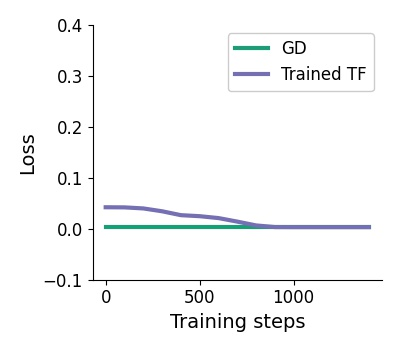

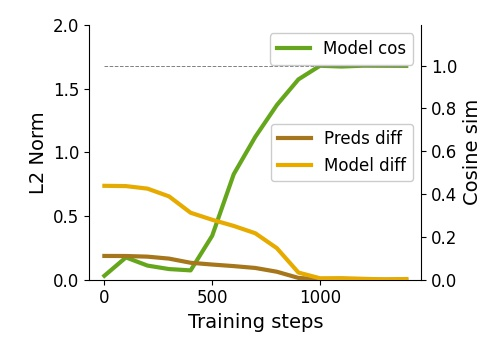

In [21]:
#@title Visualize loss and alignment measures (the printing layout is set to default and might be suboptimal)

cosine_low = 0.0
if config.num_layers == 1:
  display_learning(loss_trans_list, test=[losses_gd_list[0]], y_lim_u=0.4, y_lim_l=-0.1,
                  rw=1, title="train.pdf", allow_download=False,
                  single_seeds = True, label_title ="Loss",
                  title2='GD', title1='Trained TF',
                  title3='GD',  loc_first='upper right',
                  num_iter_os=len(loss_trans_list[0])*100)

  display_learning(cos_sim_list, grad_norm_list, p_norm_list,
                  title1="Model cos",
                  title2="Model diff", y_lim_u=2,
                  title3="Preds diff", second_axis=True, color_add=0.2,
                  y_lim_u2=1.19, loc_sec='center right', single_seeds = False,
                  y_lim_l2=cosine_low, color_axis=False, width= 5, y_label2 = 'Cosine sim',
                  rw=1, num_iter_os=len(grad_norm_list[0])*100, title="sim.pdf",
                  allow_download=False)
else:
  display_learning(loss_trans_list, gt=losses_gd_list_trained,
                   test=[losses_gd_list[0]], y_lim_u=0.3, y_lim_l=0.0,
                   rw=1, title="train.pdf", allow_download=False,
                   title2='GD', title1='Trained TF',
                   title3='GD$^{++}$',loc_first='upper right', x_label = "Training steps",
                   single_seeds = True, plot_title = None,
                   num_iter_os=len(loss_trans_list[0])*100)

  display_learning(cos_sim_list, grad_norm_list, p_norm_list, title1="Model cos",
                  title2="Model diff", y_lim_u=1.8,
                  title3="Preds diff", second_axis=True, color_add=0.2,
                  y_lim_u2=1.09999999, color_axis=False,  width= 4, x_label = "Training steps",
                  plot_title="GD vs trained TF",
                  y_lim_l2=0.5, loc_sec = 'center right', y_label1 = 'L2 Norm', y_label2 = 'Cosine sim',
                  rw=1, num_iter_os=len(loss_trans_list[0])*100, title="sim.pdf",
                  allow_download=False, plot_num=1)

  display_learning(cos_sim_list_o, grad_norm_list_o, p_norm_list_o, title1="Model cos",
                  title2="Model diff", y_lim_u=1.8, x_label = "Training steps", plot_title = "GD$^{++}$ vs trained TF" ,
                  title3="Preds diff", second_axis=True, color_add=0.2,
                  y_lim_u2=1.0599999, color_axis=False, width= 4, y_label1 = 'L2 Norm', y_label2 = 'Cosine sim',
                  y_lim_l2=0.5, loc_sec = 'center right',
                  rw=1, num_iter_os=len(loss_trans_list[0])*100, title="sim2.pdf",
                  allow_download=False)

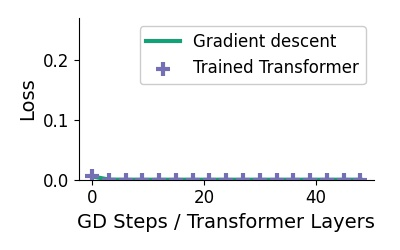

In [22]:
#@title Visualize iteratively applying a single layer Transformer layer
if config.gd_deq and config.num_heads == 1 and config.num_layers == 1:
  scale = 0.75

  train_state_final = train_state
  losses_gd, losses_tr, x_range = [], [], []

  orig_damp = config.dampening
  config.dampening = scale
  orig_num_layers = config.num_layers
  config.num_layers = 50

  config.y_update = True
  params_gd = create_weights(config.input_size, 1, config.dataset_size, lr_min*scale,
                                jax.random.normal(data_rng, shape=[1, 1, config.input_size])*0,
                              lin_diag=False,
                              gd_deq=config.gd_deq, num_layers=config.num_layers)
  x_range = np.arange(1, config.num_layers)

  _, int_params = interpolate_weights(train_state, params_gd)

  _, _, _, rng = init()
  _, _, losses_gd = predict_test.apply(params_gd, eval_rng, eval_data, True)
  _, _, losses_gd_train = predict_test.apply(params_gd_trained, eval_rng, eval_data, True)
  _, _, losses_tr = predict_test.apply(train_state.params, eval_rng, eval_data, False)
  _, _, losses_int = predict_test.apply(int_params, eval_rng, eval_data, True)
  config.num_layers = orig_num_layers
  config.orig_damp = orig_damp
  config.y_update = False
  train_state = train_state_final

if config.gd_deq and config.deq and config.num_heads == 1:
  if orig_num_layers > 1:
      display_learning([losses_tr], gt=[losses_gd_train], test=[losses_gd],
                      y_lim_u=10, y_lim_l=0.0,
                    rw=1, title="extra_gd_steps.pdf", allow_download=False,
                    title3='GD$^{++}$',
                    title2='GD', title1='Trained TF',
                    line="*", height = 2.5, loc_first='lower right',
                    x_label = 'Gradient steps / TF  steps',
                    num_iter_os=len(losses_tr))
  else:
      each = 3
      display_learning([losses_tr[0::each]], test=[losses_gd[0::each]], y_lim_u=0.27, y_lim_l=0.00,
                  rw=1, title="extra_gd_steps.pdf", allow_download=False,
                  #plot_title="Dampening $\lambda =$" +str(scale),
                  title3='GD$^{++}$' if config.pre_train_gd else 'GD',
                  title2='Gradient descent', title1='Trained Transformer',
                  line="+", height = 2.5, loc_first='upper right',
                  x_label = 'GD Steps / Transformer Layers',
                  num_iter_os=len(losses_tr[0::each])*each)


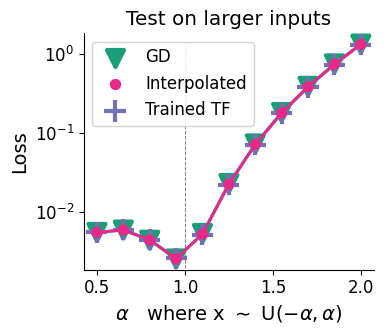

In [23]:
#@title Visualize Transformer performance on larger inputs (comment out for other OOD)

#@title Config
Test_on_larger_inputs = True #@param {type:"boolean"}
Test_on_larger_targets = False #@param {type:"boolean"}
same_distribution = True #@param {type:"boolean"}

assert Test_on_larger_inputs or Test_on_larger_targets

log = True
every = 5
l_bound, u_bound = 0.06, 10
leg_loc = 'upper left'

if Test_on_larger_inputs:

  if same_distribution:
    title = r'Test on larger inputs'

    x_axis = r'$\alpha$   where x $\sim$ U($-\alpha, \alpha$)'
    download = 'Input scale'
    data = [ir_gd_list, ir_gd_trained_list, ir_t_list, ir_inter_list, np.arange(0.5, 2+0.03, 0.03)]
    training_x = np.ones([100])
    step = np.max(np.array(data[:1]))/100.
    training_y = np.arange(0, np.max(np.array(data[:1])) - step, step)
  else:

    leg_loc = 'upper left'
    x_axis = r'$\alpha$   where $\alpha x$'
    l_bound, u_bound = 0.008, 10
    every = 5
    data = [ir_gd_ood_list, ir_gd_ood_trained_list, ir_t_ood_list, ir_inter_ood_list, np.arange(0.5, 5+0.05, 0.05)]
    training_x = np.ones([100])
    step = np.max(np.array(data[:1]))/100.
    training_y = np.arange(0, np.max(np.array(data[:1])) - step, step)

if Test_on_larger_targets:
  title = r'Test on larger targets'

  if same_distribution:
    x_axis = r'$\alpha W$   where W $\sim$ N(0, I)'
    download = 'Weight scale'
    leg_loc = 'lower right'
    data = [ws_gd_list, ws_gd_trained_list, ws_t_list, ws_inter_list, np.arange(0.5, 5+0.1, 0.1)]
    training_x = np.ones([100])
    step = np.max(np.array(data[:1]))/100.
    training_y = np.arange(0, np.max(np.array(data[:1])) - step, step)

  else:

    x_axis = r'$\alpha W$   where W $\sim$ N(0, I)'
    download = 'Weight scale ood'
    data = [ws_gd_ood_list, ws_gd_ood_trained_list, ws_t_ood_list, ws_inter_ood_list, np.arange(0.5, 5+0.1, 0.1)]
    training_x = np.ones([100])
    step = np.max(np.array(data[:1]))/100.
    training_y = np.arange(0, np.max(np.array(data[:1])) - step, step)


"""
title = r'Test on noisy data'
every = 1
log = False
l_bound, u_bound = 0.2, 0.5
x_axis = 'Number of noisy data samples'
data = [losses_gd_noisy_list, losses_gd_noisy_trained_list, losses_noisy_list, losses_inter_noisy_list, np.arange(0, config.dataset_size, 2)]
training_x = np.zeros([100])
step = np.max(np.array(data[:1]))/100.
training_y = np.arange(np.min(np.array(data[:1])), np.max(np.array(data[:1])) - step, step)

"""

pl.rcParams.update({'font.size': 12})

fig, ax1 = pl.subplots()
fig.set_size_inches(4, 3.5)
pl.xlabel(x_axis)
pl.ylabel('Loss')
if log:
  pl.yscale('log')

#print(training_x, training_y)
pl.plot(training_x[:len(training_y)], training_y, "--", color="gray", linewidth='0.7',zorder=0)

stretch = data[-1][0::every]
gd_list = np.array(data[0])
num_seeds = gd_list.shape[0]

ir_gd_std = np.std(gd_list, axis=0)[0][0::every]
ir_gd = np.mean(gd_list, axis=0)[0][0::every]

ir_gd_trained_std = np.std(data[1], axis=0)[0][0::every]
ir_gd_trained = np.mean(data[1], axis=0)[0][0::every]

ir_t_std = np.std(data[2], axis=0)[0][0::every]
ir_t = np.mean(data[2], axis=0)[0][0::every]

ax1.scatter(stretch, ir_gd, s=[150 for _ in stretch], marker="v", color=colors(0.1),
         label="GD",linewidth=3, zorder=2)
ax1.plot(stretch, ir_gd, color=colors(0.1)
         ,linewidth='2', zorder=2)

#if num_seeds > 1:
#  ax1.fill_between(stretch, ir_gd-ir_gd_std*1, ir_gd+ir_gd_std*1, alpha=0.2, facecolor=colors(0.1), zorder=1)

if config.num_layers > 1:
  ax1.scatter(stretch, ir_gd_trained, s=[150 for _ in stretch], marker="x", color=colors(0.2),
          label="GD$^{++}$", zorder=4, linewidths=3)

  ax1.plot(stretch, ir_gd_trained, color=colors(0.2), linewidth=2, zorder=4)
  #if num_seeds > 1:
  #  ax1.fill_between(stretch, ir_gd_trained-ir_gd_trained_std*1, ir_gd_trained+ir_gd_trained_std*1, alpha=0.2, facecolor=colors(0.2))

if inter:
  ir_inter_std = np.std(data[3], axis=0)[0][0::every]
  ir_inter = np.mean(data[3], axis=0)[0][0::every]
  ax1.scatter(stretch, ir_inter, s=[10 for _ in stretch], marker="o", color=colors(0.4), label="Interpolated", linewidths=5, zorder=7)
  ax1.plot(stretch, ir_inter, color=colors(0.4), linewidth=2, zorder=7)
  #ax1.plot(stretch, ir_inter, "-", color=colors(0.4))
  #if num_seeds > 1:
  #  ax1.fill_between(stretch, ir_inter-ir_inter_std*1, ir_inter+ir_inter_std*1, alpha=0.2, facecolor=colors(0.4), zorder=1)

ax1.scatter(stretch, ir_t, s=[230 for _ in stretch], marker="+", color=colors(0.3), alpha=1, label="Trained TF", zorder=5, linewidths=3)
#ax1.plot(stretch, ir_t, "-", color=colors(0.3))
#if num_seeds > 1:
#    ax1.fill_between(stretch, ir_t-ir_t_std*1, ir_t+ir_t_std*1, alpha=0.2, facecolor=colors(0.3), zorder=3)
ax1.plot(stretch, ir_t, color=colors(0.3), linewidth=2, zorder=5)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([0.1], minor= [0.1])
pl.title(title)

legend1 = ax1.legend(loc=leg_loc,
                     framealpha=0.85, facecolor='white')
if 'ood' in download:
  pl.tight_layout()
  #pl.savefig("ood.pdf", format="pdf")
  #%download_file ood.pdf
else:
  pl.tight_layout()
  #pl.savefig("normal.pdf", format="pdf")
  #%download_file normal.pdf
pl.show()

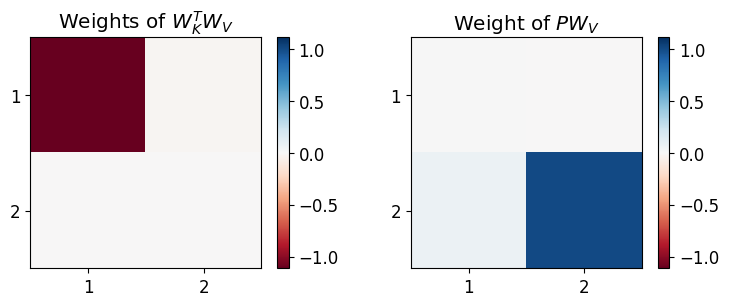

In [24]:
#@title Visualize weights of Transformer

num_dim = config.key_size
for n in range(config.num_layers):
  for head in range(config.num_heads):
    KQ = jnp.identity(config.input_size + 1) # the og was dataset_size, but I think input_size is right here
    LV = jnp.identity(config.input_size + 1)
    #print("Layer ", n, "Head ", head)
    fig, (ax1, ax2) = pl.subplots(figsize=(9, 3), ncols=2)
    ax1.set_yticks(ticks=range(0, config.key_size))
    ax1.set_yticklabels(range(1, config.key_size+1))
    ax1.set_xticks(ticks=range(0, config.key_size))
    ax1.set_xticklabels(range(1, config.key_size+1))

    ax2.set_yticks(ticks=range(0, config.key_size))
    ax2.set_yticklabels(range(1, config.key_size+1))
    ax2.set_xticks(ticks=range(0, config.key_size))
    ax2.set_xticklabels(range(1, config.key_size+1))

    for k,v in train_state.params.items():
      if config.deq == True or (str(n) in k and config.deq == False):
        #print(k, head, v['w'].shape, )
        if "key" in k:
          KQ = jnp.matmul(KQ, v['w'][:, head*num_dim: (head+1)*num_dim])
        elif "query" in k:
          KQ = jnp.matmul(KQ, v['w'][:, head*num_dim: (head+1)*num_dim].T)
        elif "value" in k:
          LV = jnp.matmul(v['w'][:, head*num_dim: (head+1)*num_dim], LV)
        elif "linear" in k:
          LV = jnp.matmul(v['w'][head*num_dim: (head+1)*num_dim, :], LV)

    if head == 0:
      first = KQ*LV[-1, -1]
    if head == 1:
      second = KQ*LV[-1, -1]

    vmin = jnp.max(jnp.abs(KQ))
    vmin2 = jnp.max(jnp.abs(LV))
    vmin = np.max([vmin, vmin2])
    ax1.set_title("Weights of $W^T_KW_V$")
    pos = ax1.imshow(KQ, cmap='RdBu', vmin=-vmin, vmax=vmin)
    fig.colorbar(pos, ax=ax1, shrink=1)
    ax2.set_title("Weight of $PW_V$")

    pos = ax2.imshow(LV, cmap='RdBu', vmin=-vmin, vmax=vmin)
    fig.colorbar(pos, ax=ax2, shrink=1)
    pl.show()
